# Задание

LDA parameters $\alpha$ and $\beta$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Dataset

In [2]:
from sklearn.datasets import fetch_20newsgroups


train_data = fetch_20newsgroups(subset='train')
val_data = fetch_20newsgroups(subset='test')

len(train_data['data']), len(val_data['data'])

(11314, 7532)

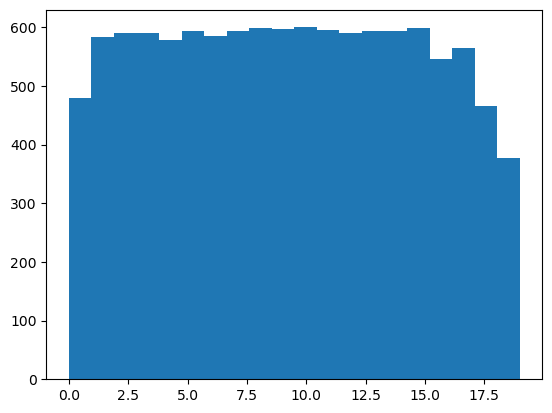

In [3]:
plt.hist(train_data['target'], bins=20)
None

## Text preprocessing

In [4]:
! pip install -qq spacy

In [5]:
from tqdm import tqdm
import re
from collections import Counter
from spacy.lang.en import stop_words


import nltk
from nltk.corpus import words
nltk.download('words')


DICT_WORDS_COUNT = 1000
stopwords = stop_words.STOP_WORDS

[nltk_data] Downloading package words to /Users/ktann/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [6]:
english_words_corpora = words.words()
len(english_words_corpora)

236736

In [7]:
def clean_text(text):

    if 'Lines:' in text:
        start = text.index('Lines:') + 5
        text = text[start:]

    text = text.lower()

    text = re.sub(r'[\w\d.]+@[\w\d]+.[\w\d]+', ' ', text)
    text = re.sub(r'(http|https)://[\w\d/.]+', ' ', text)

    text = re.sub(r'[^a-z]', ' ', text)

    text = re.sub(r'([^\w]|[-_])+', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    text = re.sub(r'\s+', ' ', text)

    text = text.strip()
    
    words = [
        w for w in text.split() \
            if len(w) > 3 and \
                w not in stopwords and \
                w in english_words_corpora
    ]

    return ' '.join(words)

In [8]:
from random import randint, seed
import warnings
warnings.filterwarnings('ignore')

In [9]:
seed(4242)
samples1000 = list(filter(lambda it: randint(0, 9) == 0, zip(train_data['data'], train_data['target'])))
# samples1000 = list(zip(train_data['data'], train_data['target']))

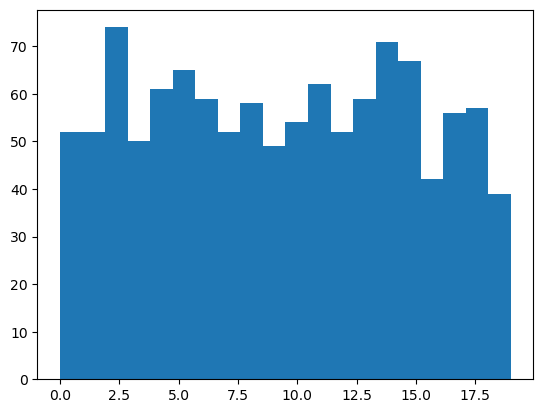

In [10]:
texts1000, targets1000 = zip(*samples1000)
plt.hist(targets1000, bins=20)
None

In [11]:
clean_train_texts = [
    clean_text(text) for text, target in tqdm(samples1000, desc='Train texts')
]

Train texts: 100%|██████████| 1131/1131 [01:37<00:00, 11.63it/s]


## LDA

In [12]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora, models
from gensim.utils import simple_preprocess
from sklearn.feature_extraction.text import TfidfVectorizer

In [13]:
# Preprocess the text data and create a list of tokenized documents
tokenized_documents = [simple_preprocess(text) for text in clean_train_texts]

# Create a dictionary mapping of words to unique IDs
dictionary = corpora.Dictionary(tokenized_documents)

# Create a Bag of Words (BoW) representation of the documents
bow_corpus = [dictionary.doc2bow(doc) for doc in tokenized_documents]

In [14]:
# Create a TF-IDF model
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [15]:
lda_models = []

In [16]:
for alpha in [0.01, 0.5, 1, 2]:
    for beta in [0.01, 0.5, 1, 2]:
        lda_model = models.LdaModel(
            corpus_tfidf, 
            num_topics=10, 
            id2word=dictionary, 
            passes=15,
            alpha=alpha,
            eta=beta,
        )
        lda_models.append(lda_model)

In [26]:
for lda_model in lda_models:
    alpha, beta = lda_model.alpha[0], lda_model.eta[0]
    print(f'LDA params: alpha={alpha:.2f}, beta={beta:.2f}')

    for topic in lda_model.print_topics(num_words=5):
        print(topic)

    print()

LDA params: alpha=0.01, beta=0.01
(0, '0.006*"moral" + 0.006*"motif" + 0.006*"window" + 0.003*"posting" + 0.003*"host"')
(1, '0.006*"mouse" + 0.003*"year" + 0.003*"article" + 0.003*"begin" + 0.003*"world"')
(2, '0.004*"game" + 0.004*"package" + 0.004*"dyer" + 0.004*"blood" + 0.003*"address"')
(3, '0.006*"screen" + 0.004*"monitor" + 0.004*"card" + 0.004*"display" + 0.004*"apple"')
(4, '0.006*"people" + 0.005*"think" + 0.004*"like" + 0.004*"time" + 0.004*"know"')
(5, '0.005*"article" + 0.003*"apple" + 0.003*"example" + 0.003*"draft" + 0.003*"pick"')
(6, '0.005*"file" + 0.005*"font" + 0.004*"wave" + 0.004*"server" + 0.004*"mail"')
(7, '0.004*"drive" + 0.004*"yeast" + 0.004*"life" + 0.003*"frank" + 0.003*"inner"')
(8, '0.008*"window" + 0.005*"game" + 0.005*"manager" + 0.004*"test" + 0.004*"berlin"')
(9, '0.005*"drive" + 0.004*"thanks" + 0.003*"government" + 0.003*"control" + 0.003*"system"')

LDA params: alpha=0.01, beta=0.50
(0, '0.000*"posting" + 0.000*"host" + 0.000*"file" + 0.000*"peop

In [35]:
def get_dataset(lda_model):
    document_topic_vectors = []
    for i, doc_bow in enumerate(bow_corpus):
        document_topics = lda_model.get_document_topics(doc_bow, minimum_probability=0.0)
        document_topic_vector = [topic_prob for _, topic_prob in document_topics]
        document_topic_vectors.append(document_topic_vector)

    df = pd.DataFrame(document_topic_vectors)
    df['target'] = targets1000
    df = df[df['target'] < 4]
    
    return df

In [36]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score


def train_and_eval_lda_catboost(df):
    X_train, X_val, y_train, y_val = train_test_split(
        df.drop('target', axis=1),
        df['target'],
        test_size=0.2,
        shuffle=True,
        random_state=42,
    )
                
    clf = CatBoostClassifier(
        iterations=2500,
        logging_level='Silent',
    )

    clf.fit(
        X=X_train,
        y=y_train,
        eval_set=(X_val, y_val),
        early_stopping_rounds=100,
    )

    y_pred = clf.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='macro')
    return acc, f1

In [37]:
for i, lda_model in enumerate(lda_models):
    df = get_dataset(lda_model)
    acc, f1 = train_and_eval_lda_catboost(df)
    alpha, beta = lda_model.alpha[0], lda_model.eta[0]
    print(f'LDA params: alpha={alpha:.2f}, beta={beta:.2f}. Accuracy={acc:.4f}, f1_score={f1:.4f}')

    if i % 4 == 3:
        print()

LDA params: alpha=0.01, beta=0.01. Accuracy=0.3913, f1_score=0.3621
LDA params: alpha=0.01, beta=0.50. Accuracy=0.4130, f1_score=0.3702
LDA params: alpha=0.01, beta=1.00. Accuracy=0.4130, f1_score=0.3667
LDA params: alpha=0.01, beta=2.00. Accuracy=0.4130, f1_score=0.3702

LDA params: alpha=0.50, beta=0.01. Accuracy=0.5652, f1_score=0.5712
LDA params: alpha=0.50, beta=0.50. Accuracy=0.4565, f1_score=0.4410
LDA params: alpha=0.50, beta=1.00. Accuracy=0.3913, f1_score=0.3514
LDA params: alpha=0.50, beta=2.00. Accuracy=0.3696, f1_score=0.3377

LDA params: alpha=1.00, beta=0.01. Accuracy=0.3696, f1_score=0.3129
LDA params: alpha=1.00, beta=0.50. Accuracy=0.4565, f1_score=0.4591
LDA params: alpha=1.00, beta=1.00. Accuracy=0.4565, f1_score=0.4563
LDA params: alpha=1.00, beta=2.00. Accuracy=0.3696, f1_score=0.2862

LDA params: alpha=2.00, beta=0.01. Accuracy=0.3043, f1_score=0.2194
LDA params: alpha=2.00, beta=0.50. Accuracy=0.4565, f1_score=0.4245
LDA params: alpha=2.00, beta=1.00. Accuracy=0